In [1]:
import duckdb
con = duckdb.connect("c:/Code/Local Code/deadlock_match_prediction/data/deadlock.db")
raw_con = duckdb.connect("c:/Code/Local Code/deadlock_match_prediction/match_player_raw.duckdb")

In [17]:
result = raw_con.execute("SELECT count(*) FROM staging_cleaned").fetchall()
print(result)

[(10235042,)]


In [18]:
con.close()
raw_con.close()

In [15]:
match_df = con.execute("SELECT * FROM matches").fetchdf()
match_ids = match_df['match_id'].unique().tolist()

# Register match_df as a temporary DuckDB view
raw_con.register("match_df", match_df)

query = """
    SELECT 
        player_count,
        COUNT(*) AS match_count
    FROM (
        SELECT 
            s.match_id,
            COUNT(*) AS player_count
        FROM staging_cleaned s
        JOIN match_df m ON s.match_id = m.match_id
        GROUP BY s.match_id
    )
    GROUP BY player_count
    ORDER BY player_count
"""

query2 = """
    SELECT COUNT(DISTINCT match_id) from match_df;
"""
result = raw_con.execute(query).fetchdf()
print(result)
result2 = raw_con.execute(query2).fetchdf()
print(result2)

Empty DataFrame
Columns: [player_count, match_count]
Index: []
   count(DISTINCT match_id)
0                     13407


In [5]:
raw_con.execute("CREATE OR REPLACE TABLE matches_for_training AS SELECT * FROM match_df")


In [7]:
result = raw_con.execute("select * from matches_for_training limit 1").fetchdf()
print(result)

   match_id          start_time game_mode match_mode  duration_s winning_team
0  35533788 2025-05-08 21:04:04    Normal   Unranked        2094        Team1


In [5]:
result = con.execute("SELECT count(distinct account_id) FROM matches").fetchdf()

BinderException: Binder Error: Referenced column "account_id" not found in FROM clause!
Candidate bindings: "match_id", "duration_s", "match_mode", "start_time", "game_mode"

LINE 1: SELECT count(distinct account_id) FROM matches
                              ^

In [8]:
result = raw_con.execute("""SELECT COUNT(*)
FROM staging_cleaned
WHERE match_id IN (
    SELECT DISTINCT match_id FROM matches_for_training
);""").fetchall()
print(result)

[(0,)]


In [38]:
raw_con.execute("""SELECT COUNT(*) AS non_unique_match_ids
FROM (
    SELECT s.account_id
    FROM staging_cleaned s
    JOIN matches_for_training m ON s.match_id = m.match_id
    GROUP BY s.account_id
    HAVING COUNT(*) > 1
);""").fetchall()

[(0,)]

*** Creates / replaces filtered_player_matches, completing with data from staginging_cleared, where match_id matches matches_for_Training

This should create match history for all players in matches_for_training

In [33]:
raw_con.execute("""
    CREATE OR REPLACE TABLE filtered_player_matches AS
    SELECT DISTINCT
        s.account_id,
        s.match_id,
        s.hero_id,
        s.team,
        s.kills,
        s.deaths,
        s.assists,
        s.denies,
        s.net_worth
    FROM staging_cleaned s
    JOIN matches_for_training m ON s.match_id = m.match_id;
                """)

In [10]:
query1 = raw_con.execute("SELECT count(distinct match_id) from filtered_player_matches").fetchall()
query2 = raw_con.execute("SELECT count(*) from filtered_player_matches").fetchall()
print(query1)
print(query2)

[(13294,)]
[(159528,)]


In [15]:
raw_con.execute("""
    SELECT 
    player_count,
    COUNT(*) AS match_count
FROM (
    SELECT 
        match_id,
        COUNT(account_id) AS player_count
    FROM filtered_player_matches
    GROUP BY match_id
)
GROUP BY player_count
ORDER BY player_count;                
                """).fetchall()

[(12, 13294)]

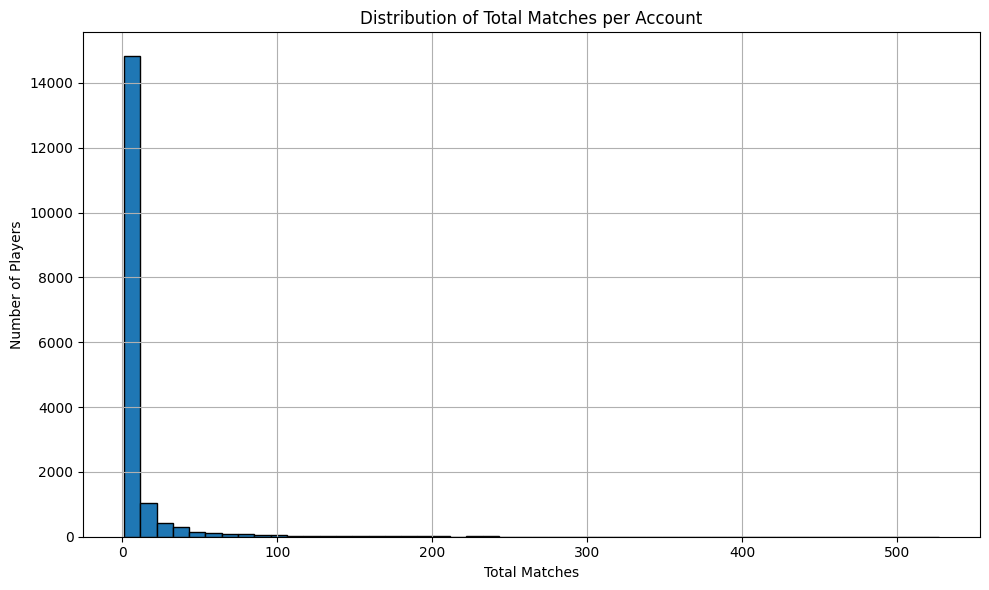

In [20]:
import duckdb
import matplotlib.pyplot as plt

df = raw_con.execute("""
    SELECT 
        account_id,
        COUNT(match_id) AS total_matches
    FROM filtered_player_matches
    GROUP BY account_id
""").fetchdf()

# Histogram for total matches
plt.figure(figsize=(10, 6))
plt.hist(df['total_matches'], bins=50, edgecolor='black')
plt.title('Distribution of Total Matches per Account')
plt.xlabel('Total Matches')
plt.ylabel('Number of Players')
plt.grid(True)
plt.tight_layout()
plt.show()

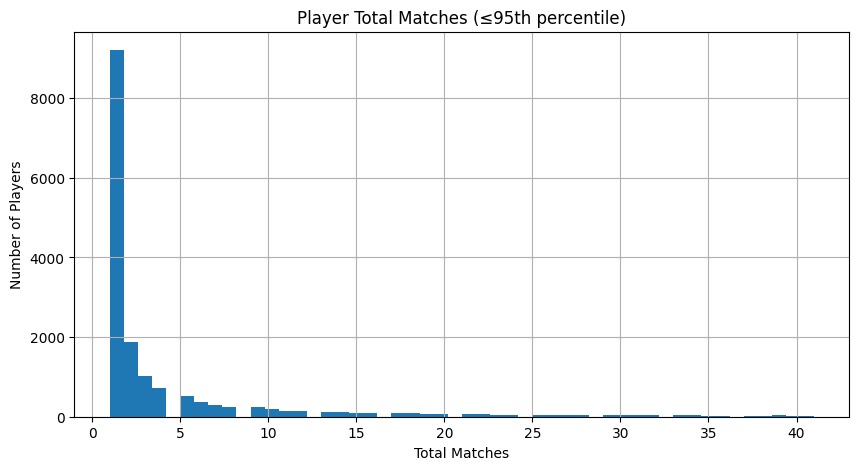

In [25]:
import numpy as np
# Fetch total match counts per player
df = raw_con.execute("""
    SELECT account_id, COUNT(*) AS total_matches
    FROM filtered_player_matches
    GROUP BY account_id
""").fetchdf()

# Calculate 95th percentile
p95 = np.percentile(df["total_matches"], 95)

# Plot
plt.figure(figsize=(10, 5))
plt.hist(df[df["total_matches"] <= p95]["total_matches"], bins=50)
plt.title("Player Total Matches (≤95th percentile)")
plt.xlabel("Total Matches")
plt.ylabel("Number of Players")
plt.grid(True)
plt.show()